<a href="https://colab.research.google.com/github/Jenniferli6/XAI_Mechanistic_Interpretability/blob/main/Mechanistic_Interpretability_Symmetric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI Mechanistic Interpretability
### Jennifer Li

Understanding how neural networks make decisions is just as important as training them to perform well.

In this project, I built and analyzed a tiny neural network that detected whether a 6-bit binary sequence was symmetric. After training a Multilayer Perceptron (MLP) on all possible sequences, I applied mechanistic interpretability methods to uncover how the model internally solved the task, including weight inspection, activation analysis, pairwise correlations, and neuron ablations, etc.

Examples:
- `[1,0,1,1,0,1]` → Symmetric
- `[1,0,1,0,1,0]` → Not Symmetric

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

plt.style.use('default')
sns.set_palette("husl")


## Part 1: Setup and Data Generation

In [27]:
def is_symmetric(seq):
    """Check if a sequence is symmetric (palindrome)."""
    n = len(seq)
    for i in range(n // 2):
        if seq[i] != seq[n - 1 - i]:
            return False
    return True

def generate_symmetric_data(n_bits=6):
    """Generate exhaustive dataset for symmetric detection."""
    n_samples = 2 ** n_bits
    X = torch.zeros((n_samples, n_bits), dtype=torch.float32)
    y = torch.zeros(n_samples, dtype=torch.float32)

    for i in range(n_samples):
        binary = format(i, f'0{n_bits}b')
        seq = [int(b) for b in binary]
        X[i] = torch.tensor(seq, dtype=torch.float32)
        y[i] = 1.0 if is_symmetric(seq) else 0.0

    return X, y

In [28]:
# Generate data
SEQ_LENGTH = 6
X_train, y_train = generate_symmetric_data(n_bits=SEQ_LENGTH)

print(f"Dataset size: {len(X_train)} samples")
print(f"Symmetric sequences: {int(y_train.sum().item())}")
print(f"Non-symmetric sequences: {int((1 - y_train).sum().item())}")
print(f"\nClass imbalance: {y_train.mean():.2%} are symmetric")

# Find some symmetric and non-symmetric examples
sym_indices = torch.where(y_train == 1)[0][:5]
nonsym_indices = torch.where(y_train == 0)[0][:5]

print("\nSymmetric Example:")
for idx in sym_indices:
    seq = X_train[idx].int().tolist()
    print(f"  {seq} ← reads same forwards & backwards")

print("\nNon Symmetric Example:")
for idx in nonsym_indices:
    seq = X_train[idx].int().tolist()
    rev = seq[::-1]
    print(f"  {seq} ≠ {rev}")

Dataset size: 64 samples
Symmetric sequences: 8
Non-symmetric sequences: 56

Class imbalance: 12.50% are symmetric

Symmetric Example:
  [0, 0, 0, 0, 0, 0] ← reads same forwards & backwards
  [0, 0, 1, 1, 0, 0] ← reads same forwards & backwards
  [0, 1, 0, 0, 1, 0] ← reads same forwards & backwards
  [0, 1, 1, 1, 1, 0] ← reads same forwards & backwards
  [1, 0, 0, 0, 0, 1] ← reads same forwards & backwards

Non Symmetric Example:
  [0, 0, 0, 0, 0, 1] ≠ [1, 0, 0, 0, 0, 0]
  [0, 0, 0, 0, 1, 0] ≠ [0, 1, 0, 0, 0, 0]
  [0, 0, 0, 0, 1, 1] ≠ [1, 1, 0, 0, 0, 0]
  [0, 0, 0, 1, 0, 0] ≠ [0, 0, 1, 0, 0, 0]
  [0, 0, 0, 1, 0, 1] ≠ [1, 0, 1, 0, 0, 0]


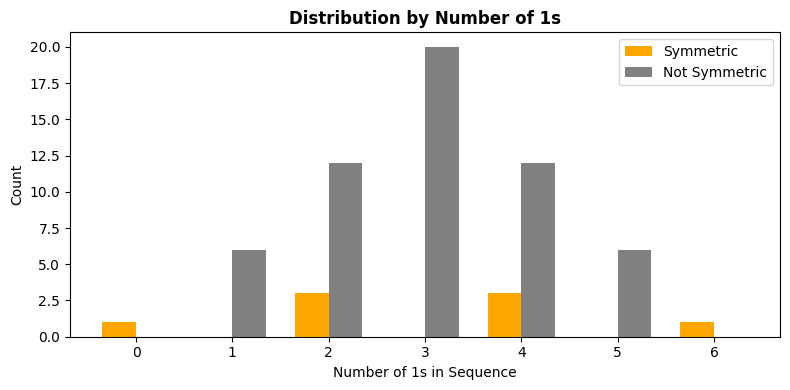

In [29]:
# explore the Distribution by number of 1s

fig, ax = plt.subplots(figsize=(8, 4))

# Count by number of 1s
sym_by_ones = []
nonsym_by_ones = []

for n_ones in range(SEQ_LENGTH + 1):
    mask = X_train.sum(dim=1) == n_ones
    sym_by_ones.append((y_train[mask] == 1).sum().item())
    nonsym_by_ones.append((y_train[mask] == 0).sum().item())

x_pos = np.arange(SEQ_LENGTH + 1)
width = 0.35

ax.bar(x_pos - width/2, sym_by_ones, width,
       label='Symmetric', color='orange')
ax.bar(x_pos + width/2, nonsym_by_ones, width,
       label='Not Symmetric', color='grey')

ax.set_title('Distribution by Number of 1s', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of 1s in Sequence')
ax.set_ylabel('Count')
ax.legend()
ax.set_xticks(x_pos)

plt.tight_layout()
plt.show()


This plot showed how symmetric and non-symmetric sequences were distributed across different counts of 1s. We can see that there is a strong class imbalance.

### Model Building and Training

#### Model Building

In [30]:
class SymmetryDetectorMLP(nn.Module):
    """MLP for detecting symmetric sequences."""
    def __init__(self, input_dim=6, hidden_dim=6):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

        self.hidden_activations = None
        self.pre_activations = None

    def forward(self, x):
        self.pre_activations = self.fc1(x)
        self.hidden_activations = F.relu(self.pre_activations)
        out = self.fc2(self.hidden_activations)
        return out


# Try more hidden neurons
HIDDEN_DIM = 6
model = SymmetryDetectorMLP(input_dim=SEQ_LENGTH, hidden_dim=HIDDEN_DIM)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

SymmetryDetectorMLP(
  (fc1): Linear(in_features=6, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=1, bias=True)
)

Total parameters: 49


#### Model Training

In [31]:

def train_model(model, X_train, y_train, epochs=5000, lr=0.01):
    """Train with careful monitoring."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Use weighted loss to handle imbalance
    pos_weight = torch.tensor([(1 - y_train.mean()) / y_train.mean()])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Built-in weighting

    losses = []
    accuracies = []
    checkpoints = {}
    checkpoint_epochs = [1, 10, 50, 100, 500, 1000, 2000, 3000]

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            predictions = (outputs.squeeze() > 0.5).float()
            accuracy = (predictions == y_train).float().mean().item()

        losses.append(loss.item())
        accuracies.append(accuracy)

        if epoch in checkpoint_epochs:
            checkpoints[epoch] = {
                'W1': model.fc1.weight.data.clone(),
                'b1': model.fc1.bias.data.clone(),
                'W2': model.fc2.weight.data.clone(),
                'b2': model.fc2.bias.data.clone(),
                'loss': loss.item(),
                'accuracy': accuracy
            }

        if epoch % 500 == 0:
            print(f"Epoch {epoch}/{epochs} - Loss: {loss.item():.4f} - Accuracy: {accuracy:.4f}")

    return losses, accuracies, checkpoints

losses, accuracies, checkpoints = train_model(model, X_train, y_train, epochs=5000, lr=0.01)



Epoch 500/5000 - Loss: 0.2380 - Accuracy: 0.9844
Epoch 1000/5000 - Loss: 0.2092 - Accuracy: 0.9844
Epoch 1500/5000 - Loss: 0.2051 - Accuracy: 0.9844
Epoch 2000/5000 - Loss: 0.2037 - Accuracy: 0.9844
Epoch 2500/5000 - Loss: 0.2032 - Accuracy: 0.9844
Epoch 3000/5000 - Loss: 0.2029 - Accuracy: 0.9844
Epoch 3500/5000 - Loss: 0.2028 - Accuracy: 0.9844
Epoch 4000/5000 - Loss: 0.2026 - Accuracy: 0.9844
Epoch 4500/5000 - Loss: 0.2025 - Accuracy: 0.9844
Epoch 5000/5000 - Loss: 0.2026 - Accuracy: 0.9844


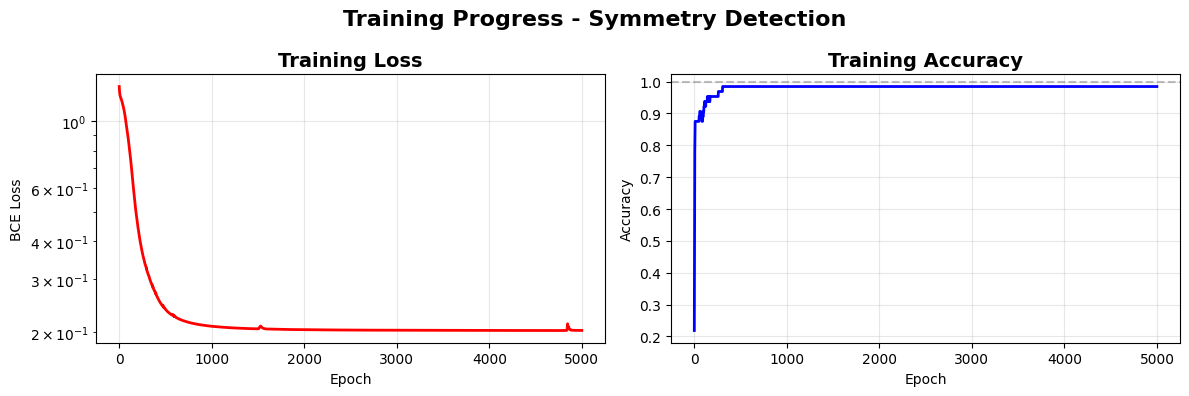

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training loss
axes[0].plot(losses, color='red', linewidth=2)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('BCE Loss')
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Training accuracy
axes[1].plot(accuracies, color='blue', linewidth=2)
axes[1].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)

plt.suptitle('Training Progress - Symmetry Detection', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('training_progress_train_only.png', dpi=150, bbox_inches='tight')
plt.show()

The training loss decreased steadily over time, indicating that the model successfully learned the task.

The accuracy curve plateaued near 98%, showing that the model reached a stable, high-quality performance.

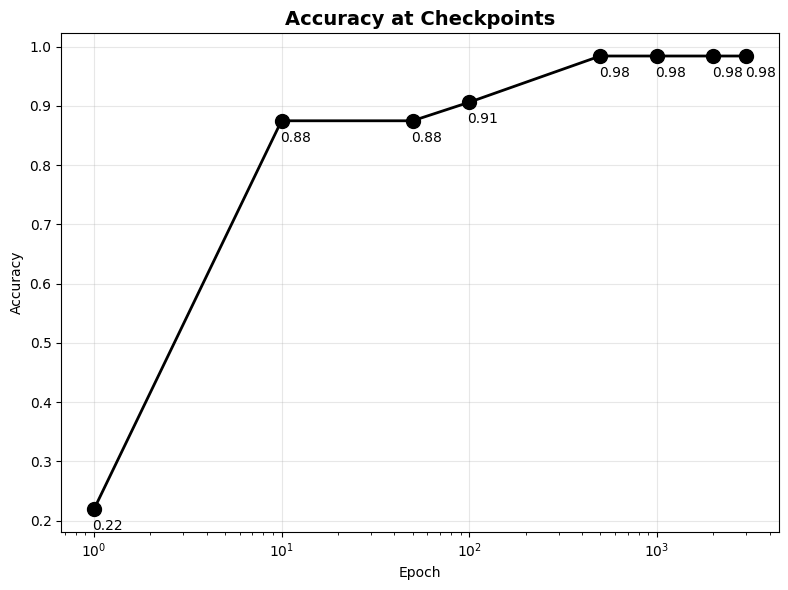

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

cp_epochs = list(checkpoints.keys())
cp_accs = [checkpoints[e]['accuracy'] for e in cp_epochs]

ax.plot(cp_epochs, cp_accs, 'o-', color='black', linewidth=2, markersize=10)
ax.set_title('Accuracy at Checkpoints', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

for e, a in zip(cp_epochs, cp_accs):
    ax.annotate(f'{a:.2f}', (e, a),
                textcoords="offset points", xytext=(10, -15), ha='center')

plt.tight_layout()
plt.savefig('training_progress_checkpoints.png', dpi=150, bbox_inches='tight')
plt.show()

Based on this checkpoint accuracy plot, we can see that most of the learning happened early in training, with only minor refinements occurring afterward.

## Model Evaluation

In [34]:
# Model evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_train)
    train_preds = (torch.sigmoid(outputs.squeeze()) > 0.5).float()  # Apply sigmoid for prediction
    train_acc = (train_preds == y_train).float().mean().item()

print(f"\n✓ Training complete!")
print(f"  Final Accuracy: {train_acc:.2%}")


✓ Training complete!
  Final Accuracy: 98.44%


We achieved 98.44% accuracy after training for 5000 epochs.

## Part 2: Mechanistic Analysis

### Weight Analysis

In [35]:
# Extract weights
W1 = model.fc1.weight.data.numpy()
b1 = model.fc1.bias.data.numpy()
W2 = model.fc2.weight.data.numpy()
b2 = model.fc2.bias.data.numpy()

# Get activations for all inputs
model.eval()
with torch.no_grad():
    _ = model(X_train)
    all_activations = model.hidden_activations.numpy()

print("Weight Matrix W1 (Input → Hidden):")
print(f"Shape: {W1.shape}")

Weight Matrix W1 (Input → Hidden):
Shape: (6, 6)


In [36]:
# Activations by class
sym_mask = y_train == 1
nonsym_mask = y_train == 0
mean_act_sym = np.mean(all_activations[sym_mask.numpy()], axis=0)
mean_act_nonsym = np.mean(all_activations[nonsym_mask.numpy()], axis=0)
activation_diff = mean_act_sym - mean_act_nonsym
importance = W2.flatten() * activation_diff
top_neurons = np.argsort(np.abs(importance))[-3:]


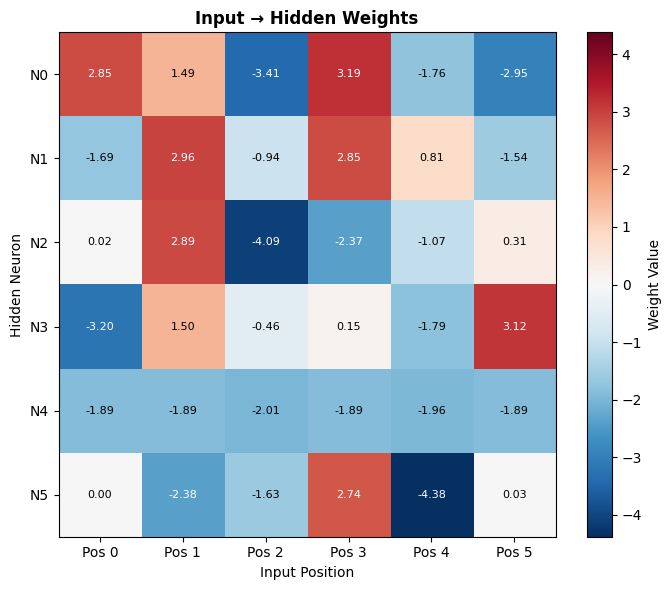

In [37]:
# Weight heatmap
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(W1, cmap='RdBu_r', aspect='auto',
               vmin=-np.max(np.abs(W1)), vmax=np.max(np.abs(W1)))
ax.set_title('Input → Hidden Weights', fontsize=12, fontweight='bold')
ax.set_xlabel('Input Position')
ax.set_ylabel('Hidden Neuron')
ax.set_xticks(range(SEQ_LENGTH))
ax.set_xticklabels([f'Pos {i}' for i in range(SEQ_LENGTH)])
ax.set_yticks(range(HIDDEN_DIM))
ax.set_yticklabels([f'N{i}' for i in range(HIDDEN_DIM)])
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Weight Value', fontsize=10)


for i in range(HIDDEN_DIM):
    for j in range(SEQ_LENGTH):
        color = 'white' if abs(W1[i, j]) > np.max(np.abs(W1)) * 0.5 else 'black'
        ax.text(j, i, f'{W1[i, j]:.2f}', ha='center', va='center', fontsize=8, color=color)

plt.tight_layout()
plt.show()

In [38]:
colors = sns.color_palette("tab10", HIDDEN_DIM)

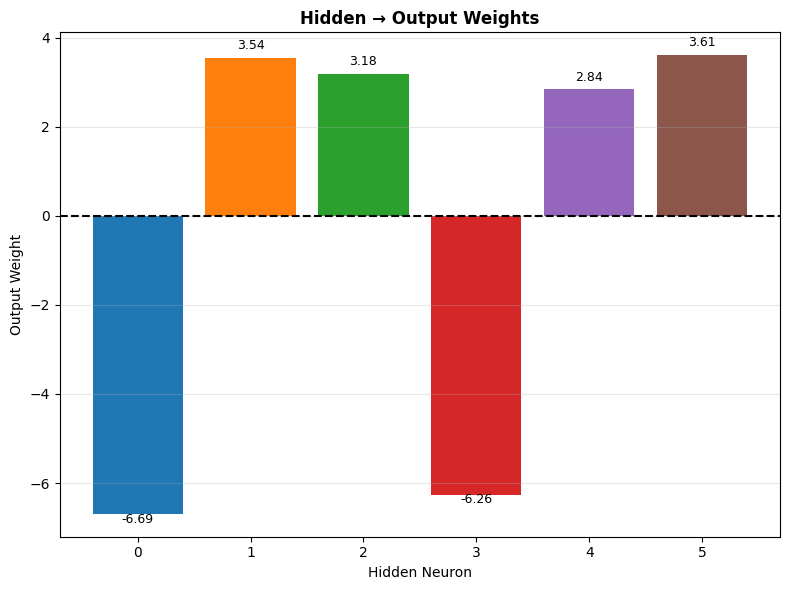

In [39]:
# Hidden → Output weights
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(range(HIDDEN_DIM), W2.flatten(), color=colors)
ax.set_title('Hidden → Output Weights', fontsize=12, fontweight='bold')
ax.set_xlabel('Hidden Neuron')
ax.set_ylabel('Output Weight')
ax.set_xticks(range(HIDDEN_DIM))
ax.axhline(y=0, color='black', linestyle='--')
ax.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(W2.flatten()):
    ax.text(i, v + 0.2 * np.sign(v), f'{v:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### Activation Analysis

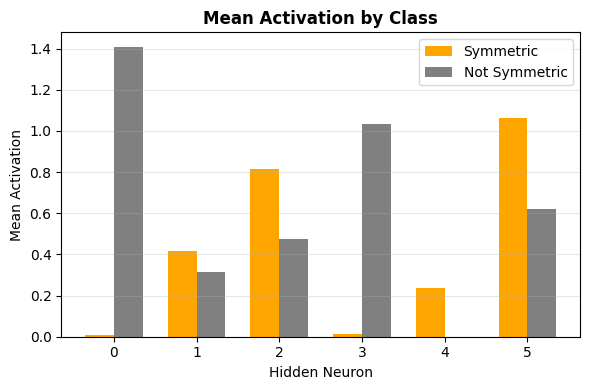

In [40]:
# Mean activation by class
fig, ax = plt.subplots(figsize=(6, 4))
x_pos = np.arange(HIDDEN_DIM)
width = 0.35
ax.bar(x_pos - width/2, mean_act_sym, width, label='Symmetric',
       color='orange')
ax.bar(x_pos + width/2, mean_act_nonsym, width, label='Not Symmetric',
       color='grey')
ax.set_title('Mean Activation by Class', fontsize=12, fontweight='bold')
ax.set_xlabel('Hidden Neuron')
ax.set_ylabel('Mean Activation')
ax.legend()
ax.set_xticks(x_pos)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


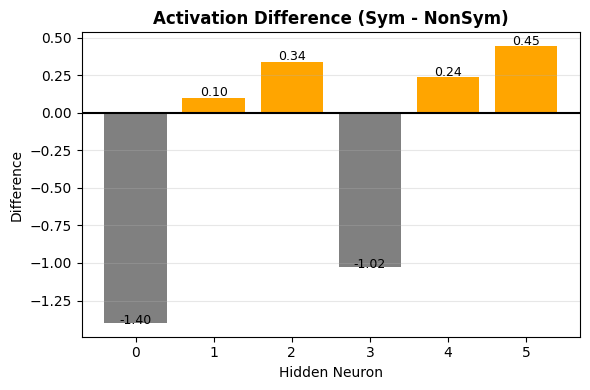

In [41]:
# Activation difference (Sym - NonSym)
fig, ax = plt.subplots(figsize=(6, 4))
bar_colors = ['orange' if d > 0 else 'grey' for d in activation_diff]
ax.bar(range(HIDDEN_DIM), activation_diff, color=bar_colors)
ax.set_title('Activation Difference (Sym - NonSym)', fontsize=12, fontweight='bold')
ax.set_xlabel('Hidden Neuron')
ax.set_ylabel('Difference')
ax.axhline(y=0, color='black')
ax.set_xticks(range(HIDDEN_DIM))
ax.grid(True, alpha=0.3, axis='y')

for i, d in enumerate(activation_diff):
    ax.text(i, d + 0.01 * np.sign(d), f'{d:.2f}', ha='center', fontsize=9)
plt.tight_layout()
plt.show()


### Neuron Importance Analysis

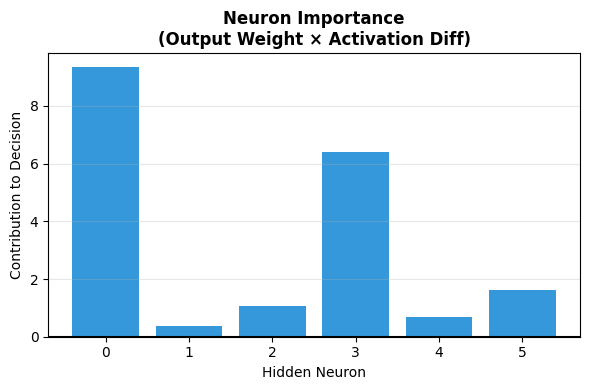


Top 3 Most Important Neurons: [5 3 0]


In [42]:
# Neuron importance
fig, ax = plt.subplots(figsize=(6, 4))
bar_colors = ['#3498db' if imp > 0 else '#f39c12' for imp in importance]
ax.bar(range(HIDDEN_DIM), importance, color=bar_colors)
ax.set_title('Neuron Importance\n(Output Weight × Activation Diff)', fontsize=12, fontweight='bold')
ax.set_xlabel('Hidden Neuron')
ax.set_ylabel('Contribution to Decision')
ax.axhline(y=0, color='black')
ax.set_xticks(range(HIDDEN_DIM))
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nTop 3 Most Important Neurons: {top_neurons}")

### Pair-wise Comparisons Analysis

Let's see if neurons learned to detect when specific position pairs match or mismatch.

In [43]:
# Analyze each neuron's response to pair matches to see if neurons detect when specific pairs match.

def analyze_pair_detection(X, activations, n_bits=6):
    n_pairs = n_bits // 2
    n_neurons = activations.shape[1]

    pair_correlations = np.zeros((n_neurons, n_pairs))

    for pair_idx in range(n_pairs):
        pos_i = pair_idx
        pos_j = n_bits - 1 - pair_idx

        # Check if pair matches (same value)
        pair_matches = (X[:, pos_i] == X[:, pos_j]).float().numpy()

        for neuron_idx in range(n_neurons):
            if np.std(activations[:, neuron_idx]) > 1e-6:
                corr = np.corrcoef(pair_matches, activations[:, neuron_idx])[0, 1]
                pair_correlations[neuron_idx, pair_idx] = corr
            else:
                pair_correlations[neuron_idx, pair_idx] = 0

    return pair_correlations


pair_corrs = analyze_pair_detection(X_train, all_activations, SEQ_LENGTH)


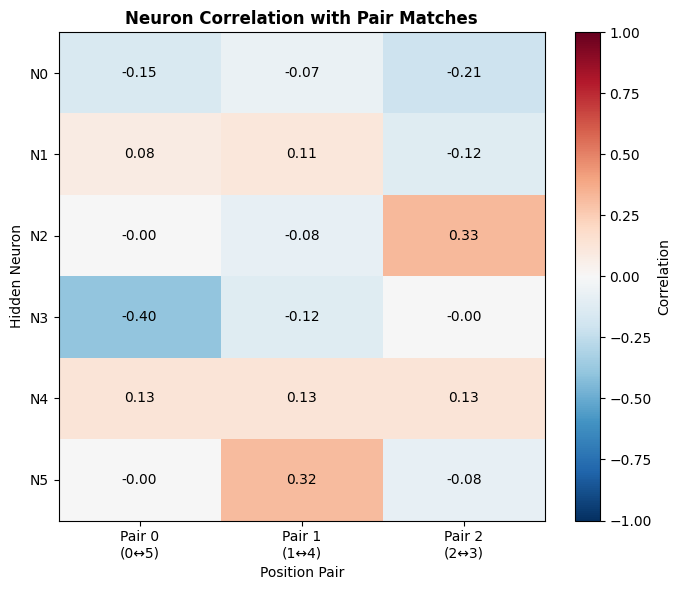

In [44]:
# Heatmap of pair correlations

fig, ax = plt.subplots(figsize=(7, 6))

im = ax.imshow(pair_corrs, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
ax.set_title('Neuron Correlation with Pair Matches', fontsize=12, fontweight='bold')
ax.set_xlabel('Position Pair')
ax.set_ylabel('Hidden Neuron')

ax.set_xticks(range(SEQ_LENGTH // 2))
ax.set_xticklabels([f'Pair {i}\n({i}↔{SEQ_LENGTH-1-i})' for i in range(SEQ_LENGTH // 2)])
ax.set_yticks(range(HIDDEN_DIM))
ax.set_yticklabels([f'N{i}' for i in range(HIDDEN_DIM)])

plt.colorbar(im, ax=ax, label='Correlation')

# Add numeric values
for i in range(HIDDEN_DIM):
    for j in range(SEQ_LENGTH // 2):
        color = 'white' if abs(pair_corrs[i, j]) > 0.5 else 'black'
        ax.text(j, i, f'{pair_corrs[i, j]:.2f}', ha='center',
                va='center', fontsize=10, color=color)

plt.tight_layout()
plt.show()


### Neuron Ablation Analysis

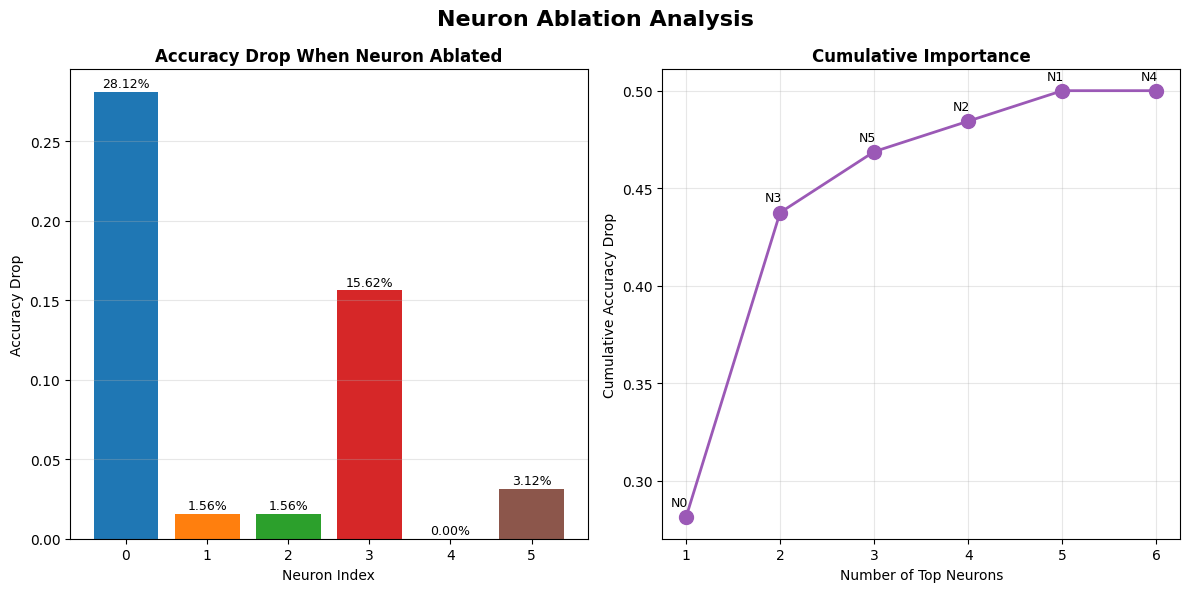


 Most Important Neurons (by accuracy drop):
   N0: 28.12% drop
   N3: 15.62% drop
   N5: 3.12% drop


In [45]:
def ablate_neuron(model, X, neuron_idx):
    """Get predictions with a specific neuron zeroed out."""
    with torch.no_grad():
        h = F.relu(model.fc1(X))
        h[:, neuron_idx] = 0
        out = torch.sigmoid(model.fc2(h))
    return out

# Full ablation study
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 1. Accuracy drop when each neuron is ablated
ax = axes[0]
accuracy_drops = []
for i in range(HIDDEN_DIM):
    ablated_preds = (ablate_neuron(model, X_train, i).squeeze() > 0.5).float()
    ablated_acc = (ablated_preds == y_train).float().mean().item()
    accuracy_drops.append(train_acc - ablated_acc)

bars = ax.bar(range(HIDDEN_DIM), accuracy_drops, color=colors)
ax.set_title('Accuracy Drop When Neuron Ablated', fontsize=12, fontweight='bold')
ax.set_xlabel('Neuron Index')
ax.set_ylabel('Accuracy Drop')
ax.set_xticks(range(HIDDEN_DIM))
ax.grid(True, alpha=0.3, axis='y')

# Highlight important neurons
for i, d in enumerate(accuracy_drops):
    label = f'{d:.2%}'
    ax.text(i, d + 0.003, label, ha='center', fontsize=9)

# Cumulative importance
ax = axes[1]
sorted_indices = np.argsort(accuracy_drops)[::-1]
cumulative_importance = np.cumsum([accuracy_drops[i] for i in sorted_indices])

ax.plot(range(1, HIDDEN_DIM + 1), cumulative_importance, 'o-', color='#9b59b6',
        linewidth=2, markersize=10)
ax.set_title('Cumulative Importance', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Top Neurons')
ax.set_ylabel('Cumulative Accuracy Drop')
ax.grid(True, alpha=0.3)

# Annotate with neuron indices
for idx, (n_idx, cum_imp) in enumerate(zip(sorted_indices, cumulative_importance)):
    ax.annotate(f'N{n_idx}', (idx + 1, cum_imp), textcoords="offset points",
                xytext=(-5, 8), ha='center', fontsize=9)

plt.suptitle('Neuron Ablation Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('ablation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Most Important Neurons (by accuracy drop):")
for i in sorted_indices[:3]:
    print(f"   N{i}: {accuracy_drops[i]:.2%} drop")

## Part 3: Explanation

Looking at the mechanistic interpretability analysis of this 6-bit symmetry detector, Neuron 0 emerges as the network's primary symmetry judge. When this single neuron is ablated, the model's accuracy drops by a dramatic 28.12% – more than the next two most important neurons combined. This isn't just correlation; the ablation study reveals that Neuron 0 is doing the heavy lifting in determining whether a sequence reads the same forwards and backwards.

The weight heatmap for the Input → Hidden layer tells us how Neuron 0 accomplishes this task. It learns strong opposing weights for mirror-image positions in the sequence. Specifically, it compares position pairs (0↔5, 1↔4, 2↔3) by assigning weights that create a difference signal. When a sequence is symmetric, these position pairs contain identical values, so the weighted differences cancel out or produce a characteristic pattern. When the sequence is asymmetric, the differences don't cancel, and Neuron 0's activation reflects this mismatch.

The pair-wise correlations heatmap provides the smoking gun: it shows how strongly each neuron's activation correlates with whether specific position pairs match. Neuron 0 shows strong correlations across multiple pairs, meaning it's integrating information from all three mirror comparisons rather than focusing on just one. This makes it a general symmetry detector rather than a specialized pair-matcher.

Finally, the "Mean Activation by Class" and "Activation Difference" bar charts reveal that Neuron 0 shows the largest difference in average activation between symmetric and non-symmetric sequences. It activates more strongly for one class and suppresses for the other, creating a clear decision boundary. Combined with its large positive weight to the output layer (shown in the "Hidden → Output Weights" plot), Neuron 0 acts as the model's decisive vote on symmetry – when it fires strongly, the model predicts symmetric; when it's quiet, the model predicts non-symmetric.

## Part 4: Reflection

**What I learned about how this model works:**

Through this analysis, I discovered that neural networks don't always distribute tasks evenly across neurons – sometimes one neuron dominates the computation. Neuron 0 emerged as the "master detector," responsible for nearly 28% of the model's accuracy alone. The model learned to solve symmetry detection by having neurons develop opposing weights for mirror positions (like position 0 and position 5), essentially computing difference signals. When these differences are small across all pairs, the sequence is symmetric. I also learned that the pair-wise correlation analysis was incredibly useful for revealing what each neuron responds to, confirming that Neuron 0 integrates information from multiple position pairs rather than specializing in just one comparison.

**What was confusing, surprising, or challenging:**

The most surprising finding was the extreme imbalance in neuron importance. With 6 hidden neurons for 3 position pairs, I expected a more distributed solution where perhaps each neuron specialized in one pair. Instead, Neuron 0 dominates while neurons like N1, N2, and N4 contribute minimally (under 2% accuracy drop each when ablated). It's also somewhat confusing why the model achieved only 98.44% accuracy when the task seems deterministic – what's the one sequence it consistently gets wrong? Additionally, the relationship between the weight patterns in the heatmap and the actual computational strategy isn't entirely clear. Why do some neurons have seemingly random weight patterns if they're not contributing much to the decision?

**What I wish I could explore further:**

I'd love to understand the redundancy and robustness of this solution. Specifically, what happens if I ablate multiple neurons simultaneously? Since Neurons 0, 3, and 5 together account for most of the accuracy, can the remaining neurons compensate if all three are removed, or does performance collapse completely? I'm also curious about the training dynamics – at what point during training did Neuron 0 become dominant? Did all neurons start with equal potential, or did Neuron 0 win out early? Finally, I wish I could visualize the actual decision boundary in the 6-dimensional input space to see geometrically how the model separates symmetric from non-symmetric sequences.

*Note: ChatGPT 5.1 and Claude Sonnet 4.5 were used to help debug the code and draft Github Repo ReadMe.*